In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [6]:
df = pd.read_csv('UBS.csv',index_col='Date',parse_dates=True)

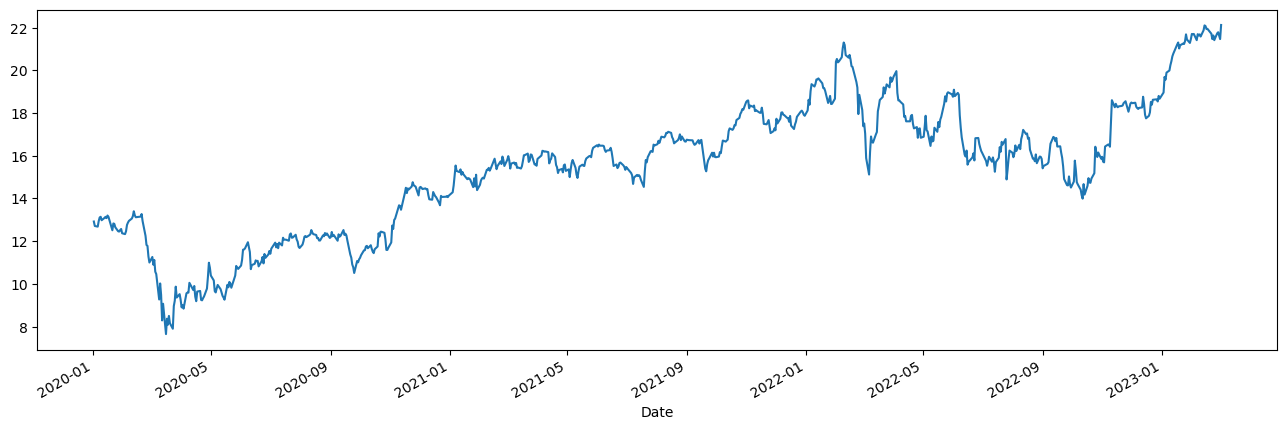

In [7]:
ax = df['Close'].plot(figsize=(16,5))
ax.autoscale(axis='Date',tight=True)

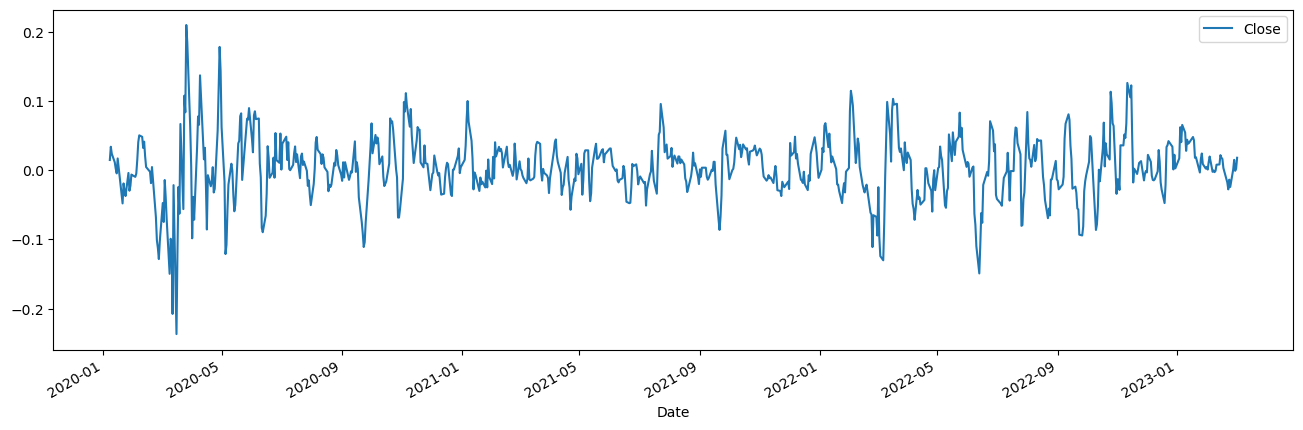

In [8]:
ax = df.pct_change(4).plot(figsize=(16,5))
ax.autoscale(axis='Date',tight=True)

In [10]:
df4 = df.pct_change(4)
df4.dropna(inplace=True)
df4

,Close
Date,
2020-01-08,0.014706
2020-01-09,0.033832
2020-01-10,0.023659
2020-01-13,0.011592
2020-01-14,0.002288
...,...
2023-02-27,0.000921
2023-02-28,0.014912
2023-03-01,-0.000925


In [265]:
from sklearn.preprocessing import StandardScaler

In [272]:
from tensorflow.keras.layers import Dense, Dropout
import seaborn as sns

In [285]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   794 non-null    int64         
 1   Date    794 non-null    datetime64[ns]
 2   Close   794 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 18.7 KB


In [286]:
df4.reset_index(inplace=True)

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [341]:
StockData = pd.DataFrame(df4['Close'])

<AxesSubplot:xlabel='TradeDate'>

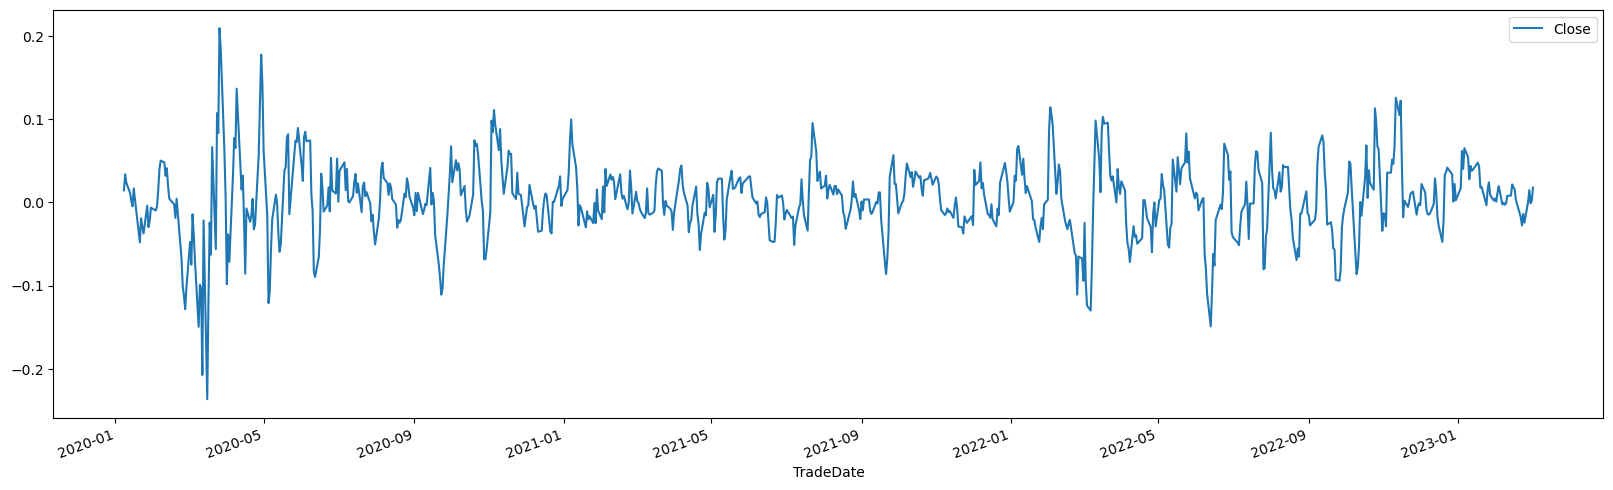

In [343]:
StockData['TradeDate']=df4.Date
 
# Plotting the stock prices
%matplotlib inline
StockData.plot(x='TradeDate', y='Close', kind='line', figsize=(20,6), rot=20)

In [347]:
FullData=StockData[['Close']].values
print(FullData[0:5])
 
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Normalization ###')
X[0:5]

[[0.01470585]
 [0.03383165]
 [0.02365925]
 [0.01159201]
 [0.00228838]]
### After Normalization ###


array([[0.56319394],
       [0.60606866],
       [0.58326496],
       [0.55621357],
       [0.53535744]])

In [349]:
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
#Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(784, 10, 1)

#### Output Data shape ####
(784, 1)


In [350]:
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(779, 10, 1)
(779, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)


In [352]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:3], y_train[0:3]):
    print(inp,'--', out)

[[0.56319394]
 [0.60606866]
 [0.58326496]
 [0.55621357]
 [0.53535744]
 [0.51999128]
 [0.56822285]
 [0.53879028]
 [0.42274772]
 [0.48738117]] -- [0.46399496]
[[0.60606866]
 [0.58326496]
 [0.55621357]
 [0.53535744]
 [0.51999128]
 [0.56822285]
 [0.53879028]
 [0.42274772]
 [0.48738117]
 [0.46399496]] -- [0.44663202]
[[0.58326496]
 [0.55621357]
 [0.53535744]
 [0.51999128]
 [0.56822285]
 [0.53879028]
 [0.42274772]
 [0.48738117]
 [0.46399496]
 [0.44663202]] -- [0.52126777]


In [353]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [354]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/100
156/156 [==============================] - 3s 5ms/step - loss: 0.1741
Epoch 2/100
156/156 [==============================] - 1s 5ms/step - loss: 0.0112
Epoch 3/100
156/156 [==============================] - 1s 5ms/step - loss: 0.0108
Epoch 4/100
156/156 [==============================] - 1s 4ms/step - loss: 0.0108
Epoch 5/100
156/156 [==============================] - 1s 4ms/step - loss: 0.0106
Epoch 6/100
156/156 [==============================] - 1s 4ms/step - loss: 0.0108
Epoch 7/100
156/156 [==============================] - 1s 5ms/step - loss: 0.0104
Epoch 8/100
156/156 [==============================] - 1s 5ms/step - loss: 0.0105
Epoch 9/100
156/156 [==============================] - 1s 4ms/step - loss: 0.0106
Epoch 10/100
156/156 [==============================] - 1s 4ms/step - loss: 0.0102
Epoch 11/100
156/156 [==============================] - 1s 5ms/step - loss: 0.0101
Epoch 12/100
156/156 [==============================] - 1s 4ms/step - loss: 0.0102
Epoch 13/100


1/1 [==============================] - 0s 14ms/step


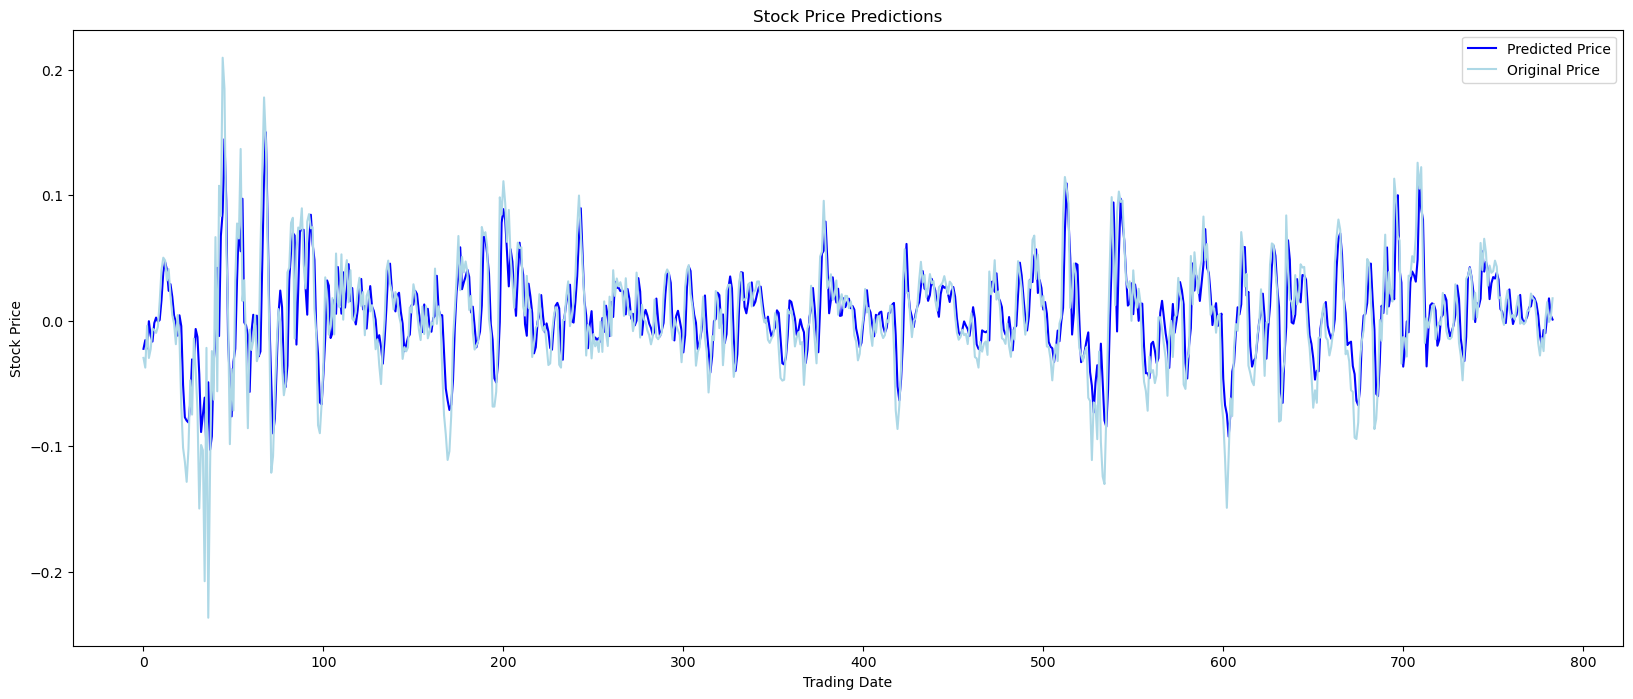

In [355]:

# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
 
# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

1/1 [==============================] - 0s 16ms/step
Accuracy: 221.74733401850148


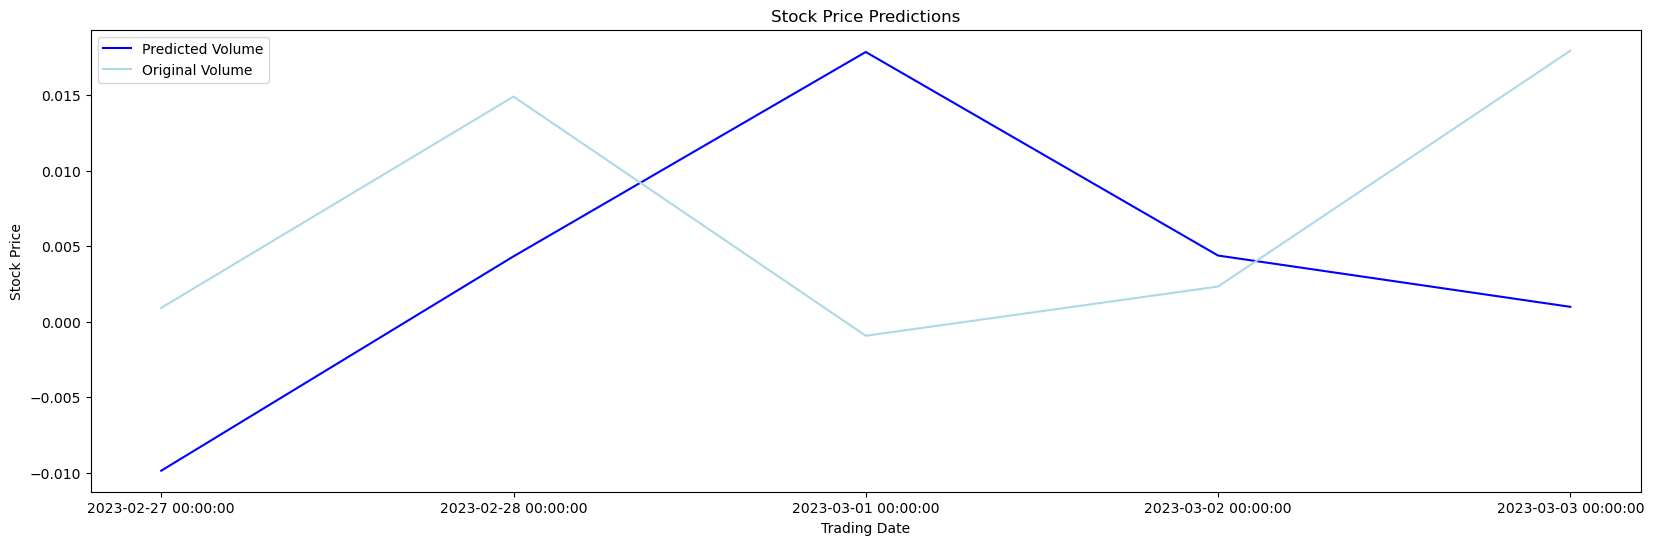

In [356]:
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
 
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())
 
# Visualising the results
import matplotlib.pyplot as plt
 
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'])
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()


In [357]:
# Printing the last 10 values
print('Original Prices')
print(FullData[-10:])
 
print('###################')
 
# Printing last 10 values of the scaled data which we have created above for the last model
# Here I am changing the shape of the data to one dimensional array because
# for Multi step data preparation we need to X input in this fashion
X=X.reshape(X.shape[0],)
print('Scaled Prices')
print(X[-10:])

Original Prices
[[ 0.00320072]
 [-0.01764712]
 [-0.02763936]
 [-0.01367994]
 [-0.02415682]
 [ 0.00092126]
 [ 0.01491154]
 [-0.00092457]
 [ 0.00233532]
 [ 0.0179476 ]]
###################
Scaled Prices
[0.53740264 0.49066761 0.46826779 0.49956091 0.47607467 0.53229272
 0.56365504 0.52815489 0.53546266 0.57046104]


In [458]:
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=30  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=10 # How many days in future you want to predict the prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
 
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

### Input Data Shape ###
(754, 30, 1)
### Output Data Shape ###
(754, 10)


In [476]:

# Choosing the number of testing data records
TestingRecords=2
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
 
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(752, 30, 1)
(752, 10)

#### Testing Data shape ####
(2, 30, 1)
(2, 10)


In [503]:
y_test

array([[0.57055363, 0.56658542, 0.53740264, 0.49066761, 0.46826779,
        0.49956091, 0.47607467, 0.53229272, 0.56365504, 0.52815489],
       [0.56658542, 0.53740264, 0.49066761, 0.46826779, 0.49956091,
        0.47607467, 0.53229272, 0.56365504, 0.52815489, 0.53546266]])

In [479]:
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)

[[0.56319394]
 [0.60606866]
 [0.58326496]
 [0.55621357]
 [0.53535744]
 [0.51999128]
 [0.56822285]
 [0.53879028]
 [0.42274772]
 [0.48738117]
 [0.46399496]
 [0.44663202]
 [0.52126777]
 [0.46383202]
 [0.47947819]
 [0.51605064]
 [0.51403529]
 [0.50862059]
 [0.51948438]
 [0.56411203]
 [0.62083873]
 [0.6429499 ]
 [0.63817564]
 [0.60225772]
 [0.62254389]
 [0.57523509]
 [0.54052631]
 [0.52512114]
 [0.48840437]
 [0.54040952]]
====>
[0.49947215 0.37839095 0.30349832 0.27851945 0.24264971 0.30148046
 0.42402087 0.36276446 0.49843009 0.44259654]
####################
[[0.60606866]
 [0.58326496]
 [0.55621357]
 [0.53535744]
 [0.51999128]
 [0.56822285]
 [0.53879028]
 [0.42274772]
 [0.48738117]
 [0.46399496]
 [0.44663202]
 [0.52126777]
 [0.46383202]
 [0.47947819]
 [0.51605064]
 [0.51403529]
 [0.50862059]
 [0.51948438]
 [0.56411203]
 [0.62083873]
 [0.6429499 ]
 [0.63817564]
 [0.60225772]
 [0.62254389]
 [0.57523509]
 [0.54052631]
 [0.52512114]
 [0.48840437]
 [0.54040952]
 [0.49947215]]
====>
[0.37839095 

In [461]:

# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 30
Number of Features: 1


In [462]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
 
# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
###################################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
147/147 [==============================] - 4s 12ms/step - loss: 0.2077
Epoch 2/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0708
Epoch 3/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0255
Epoch 4/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0140
Epoch 5/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0115
Epoch 6/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0110
Epoch 7/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0109
Epoch 8/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0110
Epoch 9/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0107
Epoch 10/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0110
Epoch 11/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0107
Epoch 12/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0107
E

In [454]:
regressor.predict([[[0.57447203],
        [0.52500458],
        [0.52919445],
        [0.52402622],
        [0.52816138],
        [0.54883105],
        [0.57893819],
        [0.57055363],
        [0.56658542],
        [0.57447203],
        [0.52500458],
        [0.52919445],
        [0.52402622],
        [0.52816138],
        [0.54883105],
        [0.57893819],
        [0.57055363],
        [0.56658542]]])

1/1 [==============================] - 0s 260ms/step


array([[0.5437514 , 0.535266  , 0.5363103 , 0.5385311 , 0.5290475 ,
        0.53290784, 0.53008825, 0.5330459 , 0.5425602 , 0.5410191 ,
        0.54667723, 0.5461174 , 0.53651905, 0.5412946 , 0.53415585]],
      dtype=float32)

In [463]:

# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
print('\n#### Original Prices ####')
print(orig)

1/1 [==============================] - 0s 264ms/step
#### Predicted Prices ####
[[-5.58358431e-03 -1.45047596e-02 -1.19162891e-02 -1.53972115e-02
  -7.74557190e-03 -7.27928430e-03 -7.60342786e-03 -8.82571470e-03
  -1.17580052e-02 -4.54343110e-03]
 [-5.66281890e-03 -1.47225214e-02 -1.21083399e-02 -1.56282689e-02
  -7.89933465e-03 -7.42964400e-03 -7.77330389e-03 -8.99505895e-03
  -1.19534861e-02 -4.66754753e-03]
 [-6.43743016e-03 -1.68512464e-02 -1.39858788e-02 -1.78868528e-02
  -9.40245204e-03 -8.89949873e-03 -9.43390653e-03 -1.06503963e-02
  -1.38645284e-02 -5.88063430e-03]
 [-6.46851212e-03 -1.69366226e-02 -1.40611921e-02 -1.79774668e-02
  -9.46272910e-03 -8.95847194e-03 -9.50053800e-03 -1.07167885e-02
  -1.39412098e-02 -5.92929171e-03]
 [-5.89711918e-03 -1.53664490e-02 -1.26763023e-02 -1.63114946e-02
  -8.35400261e-03 -7.87428766e-03 -8.27564579e-03 -9.49575193e-03
  -1.25316326e-02 -5.03455242e-03]
 [-4.93093627e-03 -1.27113201e-02 -1.03345215e-02 -1.34943863e-02
  -6.47917436e-03 -

In [475]:
len(orig)

20

        Close  TradeDate
594  0.054589 2022-05-17
595  0.038323 2022-05-18
596  0.021953 2022-05-19
597  0.040888 2022-05-20
598  0.048350 2022-05-23
599  0.083045 2022-05-24
600  0.048050 2022-05-25
601  0.061167 2022-05-26
602  0.029300 2022-05-27
603  0.004792 2022-05-31


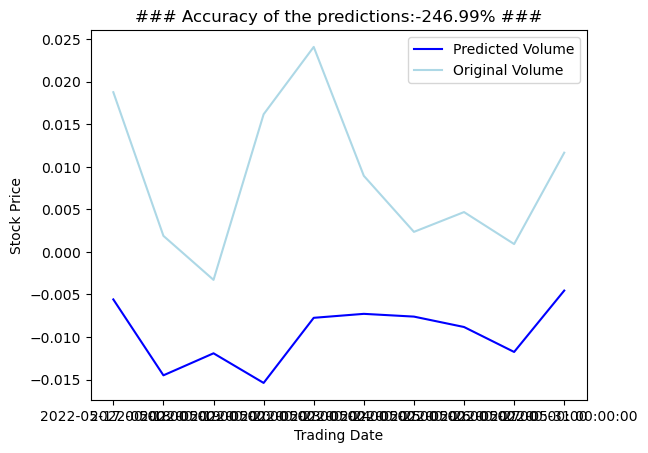

        Close  TradeDate
604  0.011866 2022-06-01
605  0.009519 2022-06-02
606 -0.009489 2022-06-03
607  0.003710 2022-06-06
608  0.005331 2022-06-07
609 -0.062860 2022-06-08
610 -0.078765 2022-06-09
611 -0.109820 2022-06-10
612 -0.148993 2022-06-13
613 -0.107881 2022-06-14


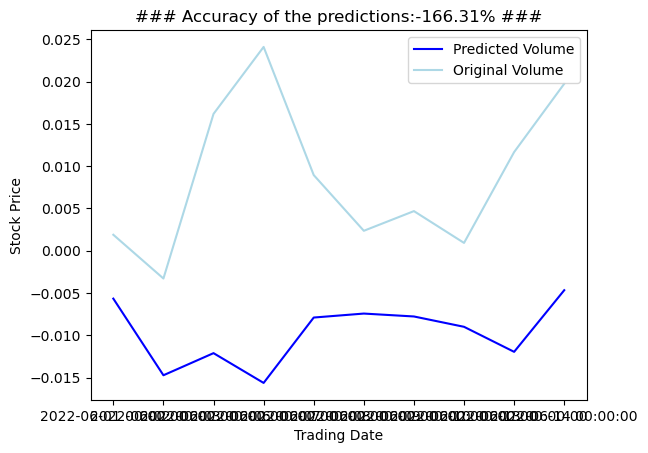

        Close  TradeDate
614 -0.061814 2022-06-15
615 -0.075919 2022-06-16
616 -0.021184 2022-06-17
617 -0.002506 2022-06-21
618 -0.008005 2022-06-22
619  0.012837 2022-06-23
620  0.070656 2022-06-24
621  0.057161 2022-06-27
622  0.027312 2022-06-28
623  0.037389 2022-06-29


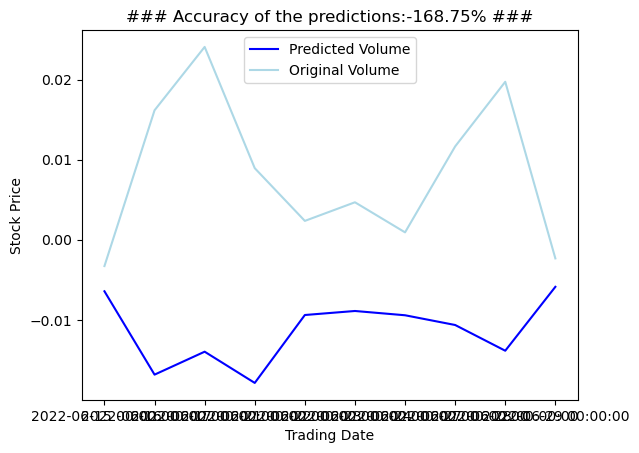

        Close  TradeDate
624 -0.035672 2022-06-30
625 -0.041592 2022-07-01
626 -0.048338 2022-07-05
627 -0.051313 2022-07-06
628 -0.028977 2022-07-07
629 -0.011159 2022-07-08
630 -0.001905 2022-07-11
631  0.025113 2022-07-12
632 -0.003175 2022-07-13
633 -0.043887 2022-07-14


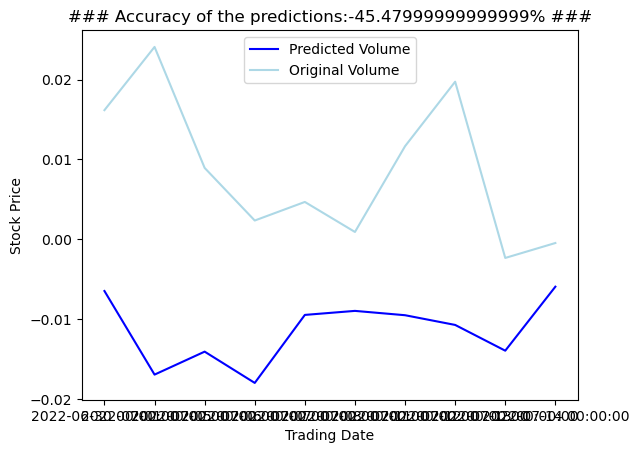

        Close  TradeDate
634 -0.001272 2022-07-15
635 -0.001256 2022-07-18
636  0.044586 2022-07-19
637  0.061639 2022-07-20
638  0.060510 2022-07-21
639  0.038994 2022-07-22
640  0.023171 2022-07-25
641 -0.080296 2022-07-26
642 -0.079279 2022-07-27
643 -0.041768 2022-07-28


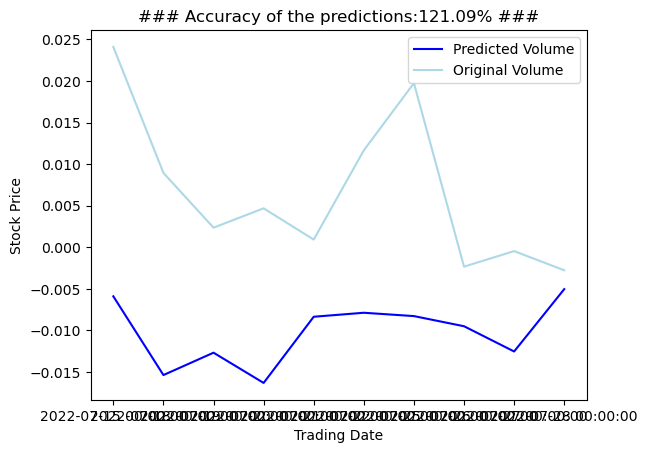

        Close  TradeDate
644 -0.032181 2022-07-29
645  0.083949 2022-08-01
646  0.039139 2022-08-02
647  0.017056 2022-08-03
648  0.014778 2022-08-04
649  0.004957 2022-08-05
650  0.036409 2022-08-08
651  0.013043 2022-08-09
652  0.018204 2022-08-10
653  0.045006 2022-08-11


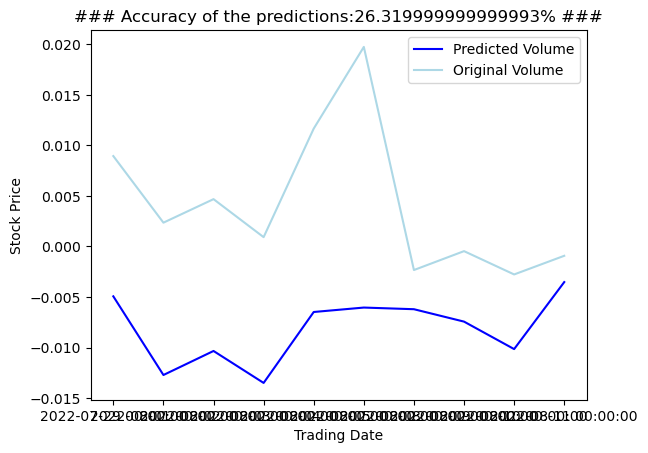

        Close  TradeDate
654  0.042398 2022-08-12
655  0.042919 2022-08-15
656  0.015495 2022-08-16
657 -0.009440 2022-08-17
658 -0.021499 2022-08-18
659 -0.042916 2022-08-19
660 -0.069249 2022-08-22
661 -0.055390 2022-08-23
662 -0.065321 2022-08-24
663 -0.013514 2022-08-25


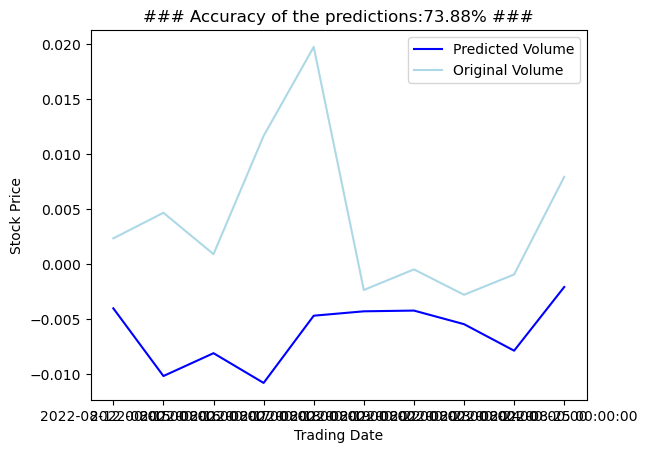

        Close  TradeDate
664 -0.013241 2022-08-26
665  0.006305 2022-08-29
666  0.013342 2022-08-30
667 -0.013076 2022-08-31
668 -0.015335 2022-09-01
669 -0.027569 2022-09-02
670 -0.020690 2022-09-06
671 -0.009464 2022-09-07
672  0.045425 2022-09-08
673  0.067010 2022-09-09


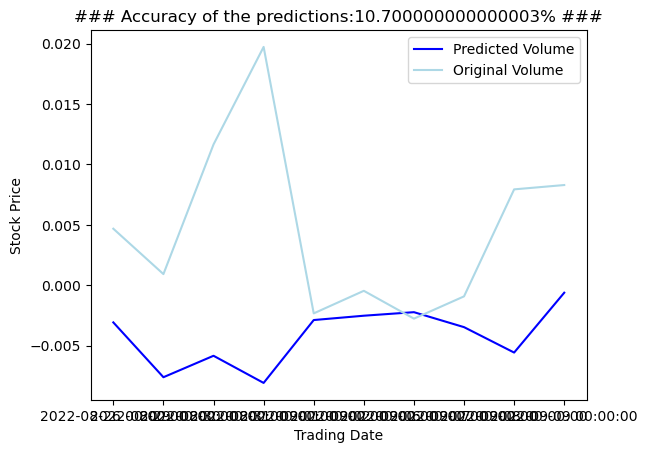

        Close  TradeDate
674  0.080666 2022-09-12
675  0.072611 2022-09-13
676  0.035382 2022-09-14
677  0.016304 2022-09-15
678 -0.026659 2022-09-16
679 -0.023753 2022-09-19
680 -0.032374 2022-09-20
681 -0.055258 2022-09-21
682 -0.056604 2022-09-22
683 -0.093066 2022-09-23


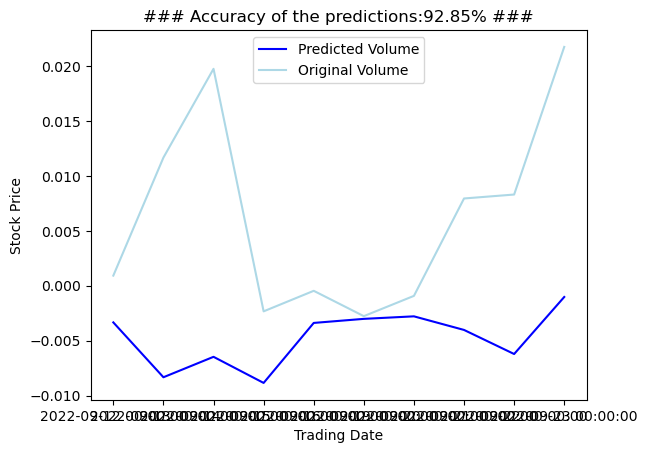

        Close  TradeDate
684 -0.094176 2022-09-26
685 -0.081132 2022-09-27
686 -0.030323 2022-09-28
687 -0.016097 2022-09-29
688 -0.007524 2022-09-30
689  0.012320 2022-10-03
690  0.049235 2022-10-04
691  0.046353 2022-10-05
692  0.017229 2022-10-06
693 -0.008790 2022-10-07


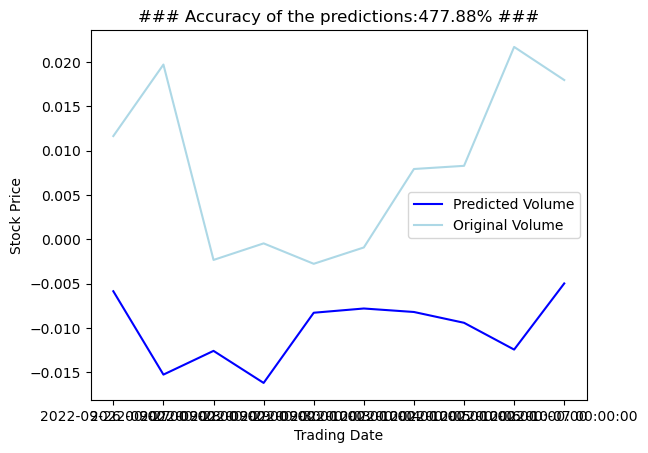

        Close  TradeDate
694 -0.086240 2022-10-10
695 -0.078176 2022-10-11
696 -0.052168 2022-10-12
697  0.000682 2022-10-13
698 -0.015961 2022-10-14
699  0.031095 2022-10-17
700  0.068620 2022-10-18
701  0.005453 2022-10-19
702  0.038787 2022-10-20
703  0.023304 2022-10-21


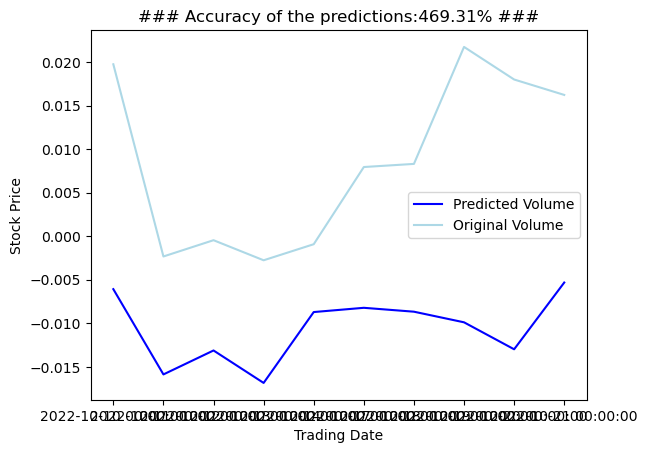

        Close  TradeDate
704  0.015385 2022-10-24
705  0.113220 2022-10-25
706  0.097081 2022-10-26
707  0.067649 2022-10-27
708  0.063900 2022-10-28
709 -0.034105 2022-10-31
710 -0.012995 2022-11-01
711 -0.013802 2022-11-02
712 -0.028483 2022-11-03
713  0.035940 2022-11-04


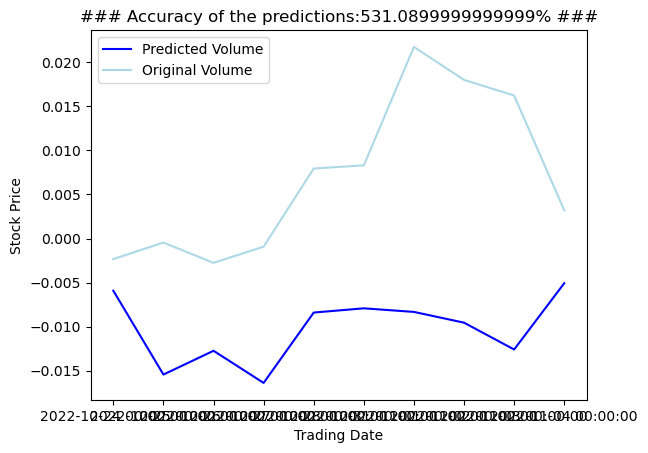

        Close  TradeDate
714  0.035737 2022-11-07
715  0.051527 2022-11-08
716  0.046526 2022-11-09
717  0.067559 2022-11-10
718  0.125908 2022-11-11
719  0.105263 2022-11-14
720  0.122412 2022-11-15
721  0.044470 2022-11-16
722 -0.017742 2022-11-17
723  0.002189 2022-11-18


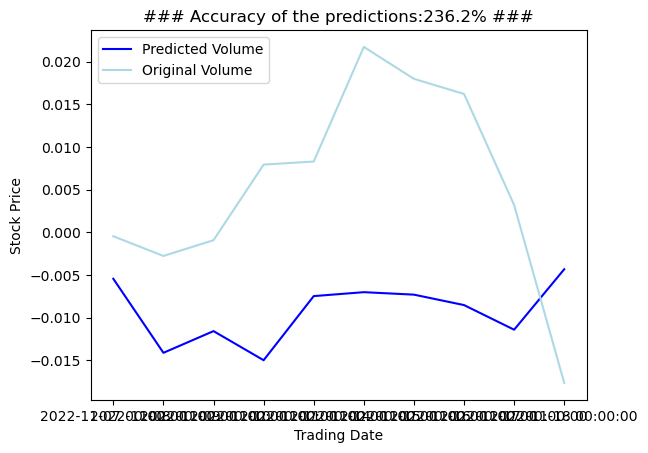

        Close  TradeDate
724 -0.005426 2022-11-21
725  0.001638 2022-11-22
726  0.010399 2022-11-23
727  0.013108 2022-11-25
728 -0.014730 2022-11-28
729 -0.004905 2022-11-29
730 -0.001083 2022-11-30
731 -0.003234 2022-12-01
732  0.022148 2022-12-02
733  0.012048 2022-12-05


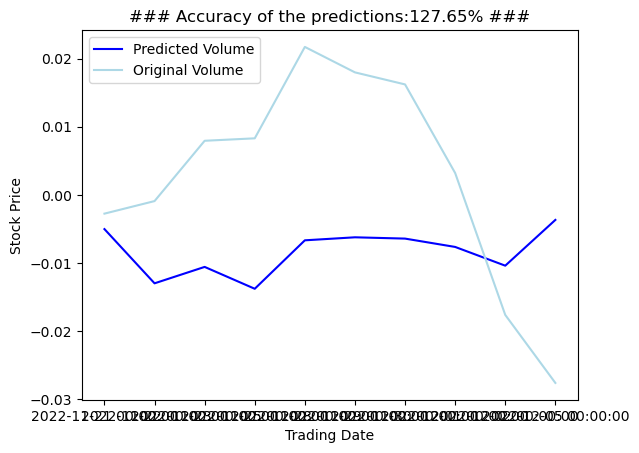

        Close  TradeDate
734 -0.008134 2022-12-06
735 -0.014062 2022-12-07
736 -0.014626 2022-12-08
737 -0.012987 2022-12-09
738 -0.001640 2022-12-12
739  0.029073 2022-12-13
740  0.012644 2022-12-14
741 -0.017544 2022-12-15
742 -0.027930 2022-12-16
743 -0.047441 2022-12-19


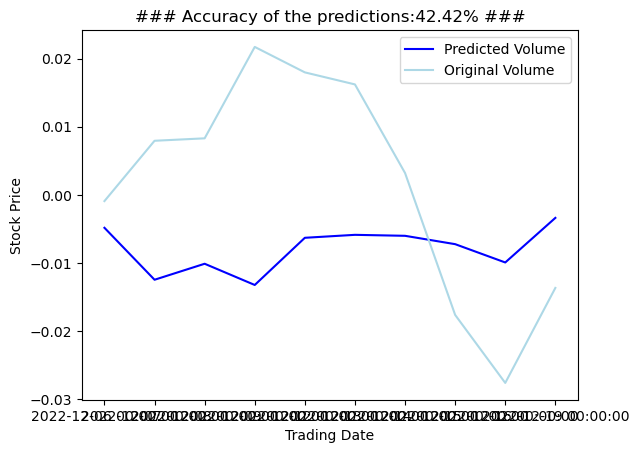

        Close  TradeDate
744 -0.021173 2022-12-20
745  0.033482 2022-12-21
746  0.036056 2022-12-22
747  0.041970 2022-12-23
748  0.033832 2022-12-27
749  0.001080 2022-12-28
750  0.022295 2022-12-29
751  0.002685 2022-12-30
752  0.017167 2023-01-03
753  0.062028 2023-01-04


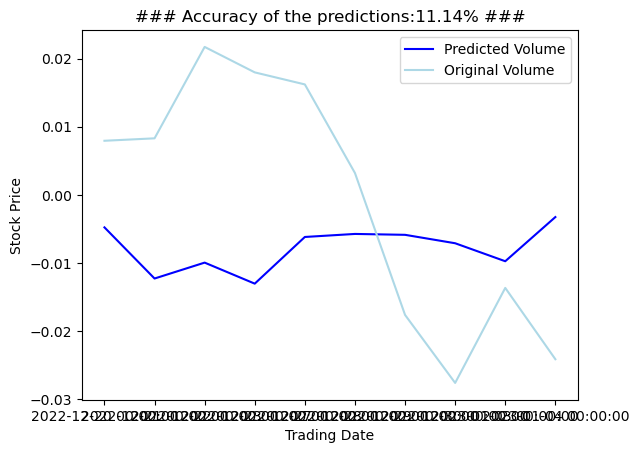

        Close  TradeDate
754  0.040426 2023-01-05
755  0.065345 2023-01-06
756  0.054325 2023-01-09
757  0.027933 2023-01-10
758  0.043967 2023-01-11
759  0.038210 2023-01-12
760  0.039520 2023-01-13
761  0.047925 2023-01-17
762  0.043095 2023-01-18
763  0.017918 2023-01-19


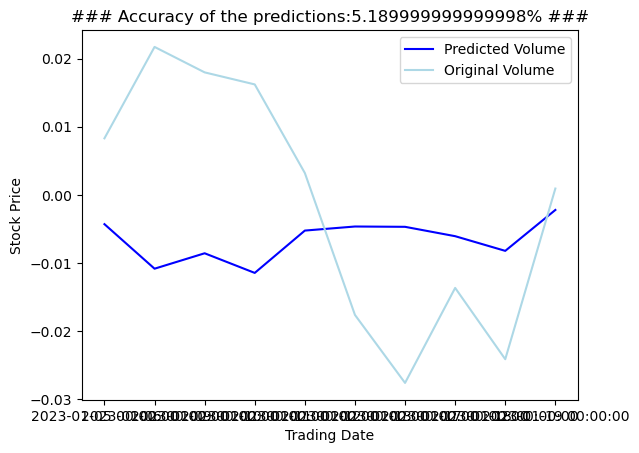

        Close  TradeDate
764  0.018768 2023-01-20
765  0.001886 2023-01-23
766 -0.003286 2023-01-24
767  0.016175 2023-01-25
768  0.024091 2023-01-26
769  0.008941 2023-01-27
770  0.002355 2023-01-30
771  0.004682 2023-01-31
772  0.000923 2023-02-01
773  0.011660 2023-02-02


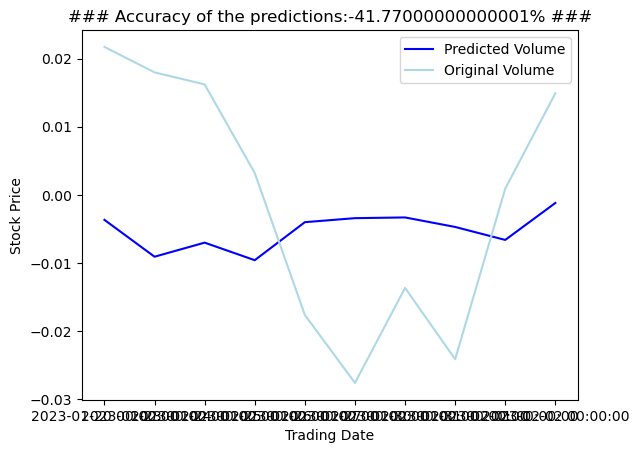

        Close  TradeDate
774  0.019737 2023-02-03
775 -0.002330 2023-02-06
776 -0.000461 2023-02-07
777 -0.002766 2023-02-08
778 -0.000922 2023-02-09
779  0.007940 2023-02-10
780  0.008299 2023-02-13
781  0.021729 2023-02-14
782  0.017989 2023-02-15
783  0.016219 2023-02-16


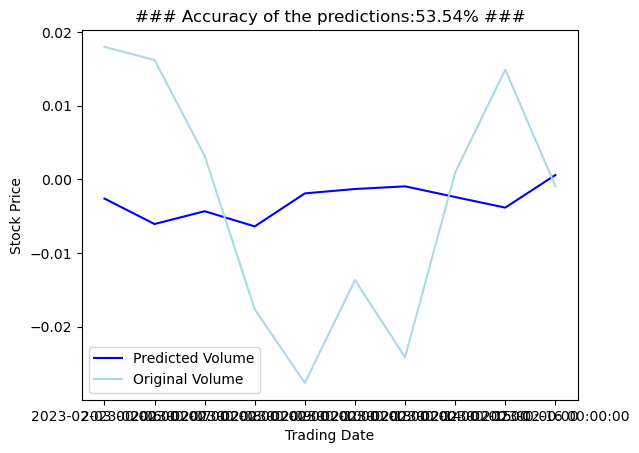

        Close  TradeDate
784  0.003201 2023-02-17
785 -0.017647 2023-02-21
786 -0.027639 2023-02-22
787 -0.013680 2023-02-23
788 -0.024157 2023-02-24
789  0.000921 2023-02-27
790  0.014912 2023-02-28
791 -0.000925 2023-03-01
792  0.002335 2023-03-02
793  0.017948 2023-03-03


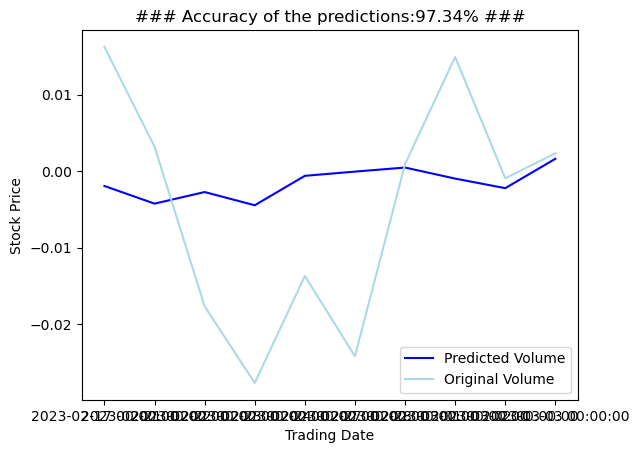

In [471]:
for i in range(len(orig)):
    Prediction=predicted_Price[i]
    Original=orig[i]
    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')
 
    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Trading Date')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=StockData.shape[0]
    print(StockData.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex)])
    plt.xticks(range(FutureTimeSteps), StockData.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['TradeDate'])
    plt.ylabel('Stock Price')
 
    plt.legend()
    #fig=plt.gcf()
   # fig.set_figwidth(20)
   # fig.set_figheight(3)
    plt.show()

In [498]:
Last10DaysPrices=np.array([0.04042555,  0.06534544,  0.05432493,  0.02793292,  0.04396731,
        0.03821017,  0.03951981,  0.04792487,  0.04309496,  0.01791772,
        0.01876802,  0.00188595, -0.00328637,  0.01617508,  0.02409071,
        0.0089412 ,  0.00235521,  0.00468158,  0.00092253,  0.01166045,
        0.01973685, -0.00232988, -0.00046084, -0.00276631, -0.00092168,
        0.00794022,  0.00829877,  0.02172914,  0.0179889 ,  0.01621874])
 
# Reshaping the data to (-1,1 )because its a single entry
Last10DaysPrices=Last10DaysPrices.reshape(-1, 1)
 
# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last10DaysPrices)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
# Generating the predictions for next 5 days
Next5DaysPrice = regressor.predict(X_test)
 
# Generating the prices in original scale
Next5DaysPrice = DataScaler.inverse_transform(Next5DaysPrice)
Next5DaysPrice

1/1 [==============================] - 0s 17ms/step


array([[-0.00167883, -0.00357714, -0.00215775, -0.00375204, -0.00012658,
         0.00038278,  0.00098079, -0.00043685, -0.00166668,  0.00195362]],
      dtype=float32)

<AxesSubplot:>

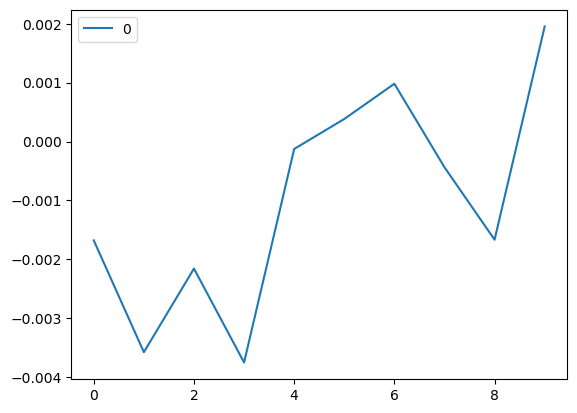

In [499]:
pd.DataFrame(Next5DaysPrice.reshape(-1,1)).plot()


<AxesSubplot:>

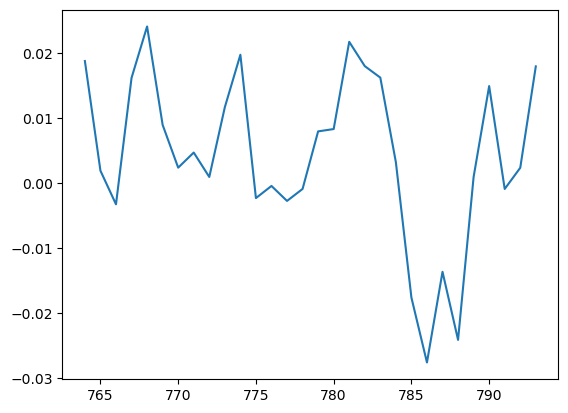

In [501]:
df4.tail(30)['Close'].plot()

In [365]:
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
 
# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')

AttributeError: 'numpy.ndarray' object has no attribute 'plot'